### Общая часть: подготовка данных


Общая часть. Подготовка данных и выбор целевой переменной.

Используем набор данных `datasets/famcs_students.csv` и список бинарных столбцов:

```python
binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", "glasses", "anime", "study_form", "literature"]
```

**N = 3**.

Целевая переменная определяется как `y = binary_cols[N % 8]` — в нашем случае это столбец **`bad_sleep`**.
Остальные переменные будут использоваться в качестве признаков `X` (предикторов). Мы отберём не менее 5 информативных признаков.
Также в этой части случайно разобьём данные на три выборки:

- **тренировочная (70%)** — для обучения моделей;
- **валидационная (15%)** — для подбора гиперпараметров и порога классификации;
- **тестовая (15%)** — для итоговой оценки качества.

Ниже также определим вспомогательные функции для оценки качества классификаторов.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

df = pd.read_csv("famcs_students.csv")

binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", "glasses", "anime", "study_form", "literature"]
N = 3
target_col = binary_cols[N % 8]
print(f"Целевая переменная y: {target_col}")

Целевая переменная y: bad_sleep


In [2]:
feature_cols = ["age", "sex", "weekend_study", "glasses", "anime", "study_form", "score"]
feature_cols = [c for c in feature_cols if c != target_col]

print("Используемые признаки X:", feature_cols)

data = df[feature_cols + [target_col]].dropna()

y_raw = data[target_col]

if set(y_raw.unique()) <= {"Да", "Нет"}:
    y = (y_raw == "Да").astype(int)
else:
    most_common = y_raw.value_counts().idxmax()
    print(f"Используем маппинг: {most_common} -> 1, остальные -> 0.")
    y = (y_raw == most_common).astype(int)

X_raw = data[feature_cols]

Используемые признаки X: ['age', 'sex', 'weekend_study', 'glasses', 'anime', 'study_form', 'score']


In [3]:
X_encoded = pd.get_dummies(X_raw, drop_first=True)
print("Размерность X после one-hot кодирования:", X_encoded.shape)

X_encoded = X_encoded.apply(pd.to_numeric, errors="coerce")
X = X_encoded.astype(float).values
y = y.values

n_samples = X.shape[0]
print("Число наблюдений после очистки:", n_samples)

Размерность X после one-hot кодирования: (127, 7)
Число наблюдений после очистки: 127


In [4]:
rng = np.random.RandomState(RANDOM_STATE)
indices = rng.permutation(n_samples)

n_train = int(0.7 * n_samples)
n_val = int(0.15 * n_samples)
n_test = n_samples - n_train - n_val

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

X_train_raw, y_train = X[train_idx], y[train_idx]
X_val_raw, y_val = X[val_idx], y[val_idx]
X_test_raw, y_test = X[test_idx], y[test_idx]

print(f"Размер train: {X_train_raw.shape[0]}, val: {X_val_raw.shape[0]}, test: {X_test_raw.shape[0]}")

Размер train: 88, val: 19, test: 20


In [5]:
def standardize_train_val_test(X_train, X_val, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1.0
    X_train_scaled = (X_train - mean) / std
    X_val_scaled = (X_val - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_val_scaled, X_test_scaled, mean, std

X_train, X_val, X_test, X_mean, X_std = standardize_train_val_test(
    X_train_raw, X_val_raw, X_test_raw
)

print("Размерность X_train (масштабированного):", X_train.shape)

Размерность X_train (масштабированного): (88, 7)


In [6]:
def confusion_matrix_binary(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp],
                     [fn, tp]])

def classification_metrics(y_true, y_pred):
    cm = confusion_matrix_binary(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    accuracy = (tn + tp) / total if total > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "cm": cm,
    }

def f1_from_pr(precision, recall):
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

def roc_auc(y_true, y_scores):
    y_true = np.asarray(y_true)
    y_scores = np.asarray(y_scores)
    order = np.argsort(y_scores)
    y_true_sorted = y_true[order]
    n_pos = np.sum(y_true_sorted == 1)
    n_neg = np.sum(y_true_sorted == 0)
    if n_pos == 0 or n_neg == 0:
        return np.nan
    ranks = np.arange(1, len(y_scores) + 1)
    ranks_pos = ranks[y_true_sorted == 1]
    sum_ranks_pos = ranks_pos.sum()
    auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
    return auc

metrics_test = {}

### Задание 0: тривиальный классификатор


**Задание 0. Тривиальный классификатор.**

Построить тривиальный классификатор, который **всегда выдаёт наиболее частый класс** (по тренировочной выборке).

Для такого классификатора по отложенной тестовой выборке необходимо оценить:

- accuracy
- precision
- recall
- roc-auc
- матрицу ошибок


In [7]:
from collections import Counter

majority_class = Counter(y_train).most_common(1)[0][0]
print("Наиболее частый класс (по train):", majority_class)

Наиболее частый класс (по train): 1


In [8]:
y_test_pred_baseline = np.full_like(y_test, fill_value=majority_class)

p_class1_train = y_train.mean()
y_test_proba_baseline = np.full_like(y_test, fill_value=p_class1_train, dtype=float)

m_baseline = classification_metrics(y_test, y_test_pred_baseline)
auc_baseline = roc_auc(y_test, y_test_proba_baseline)

print("Метрики тривиального классификатора (test):")
print("accuracy :", m_baseline['accuracy'])
print("precision:", m_baseline['precision'])
print("recall   :", m_baseline['recall'])
print("roc-auc  :", auc_baseline)
print("Матрица ошибок (tn, fp; fn, tp):\n", m_baseline['cm'])

metrics_test['baseline'] = {
    "accuracy": m_baseline['accuracy'],
    "precision": m_baseline['precision'],
    "recall": m_baseline['recall'],
    "roc_auc": auc_baseline,
    "cm": m_baseline['cm'].tolist(),
}

Метрики тривиального классификатора (test):
accuracy : 0.75
precision: 0.75
recall   : 1.0
roc-auc  : 0.6266666666666667
Матрица ошибок (tn, fp; fn, tp):
 [[ 0  5]
 [ 0 15]]


### Задание 1: наивный байесовский классификатор


**Задание 1. Наивный байесовский классификатор.**

Реализуем модель гауссовского наивного байесовского классификатора. Для каждого класса оцениваем априорную вероятность,
а для каждого признака и класса — параметры нормального распределения (среднее и дисперсию). Далее используем формулу Байеса
с предположением независимости признаков и выбираем класс с максимальной апостериорной вероятностью.


In [9]:
def train_gaussian_nb(X_train, y_train):
    classes = np.array([0, 1])
    priors = []
    means = []
    vars_ = []
    for c in classes:
        X_c = X_train[y_train == c]
        prior = len(X_c) / len(X_train)
        mean = X_c.mean(axis=0)
        var = X_c.var(axis=0) + 1e-6
        priors.append(prior)
        means.append(mean)
        vars_.append(var)
    return {
        "classes": classes,
        "priors": np.array(priors),
        "means": np.vstack(means),
        "vars": np.vstack(vars_),
    }

def gaussian_nb_predict_proba(model, X):
    classes = model["classes"]
    priors = model["priors"]
    means = model["means"]
    vars_ = model["vars"]

    log_probs = []
    for idx, c in enumerate(classes):
        mean = means[idx]
        var = vars_[idx]
        log_likelihood = -0.5 * (
            np.sum(np.log(2 * np.pi * var)) + np.sum(((X - mean) ** 2) / var, axis=1)
        )
        log_prior = np.log(priors[idx])
        log_probs.append(log_prior + log_likelihood)

    log_probs = np.vstack(log_probs).T
    max_log = np.max(log_probs, axis=1, keepdims=True)
    probs = np.exp(log_probs - max_log)
    probs /= probs.sum(axis=1, keepdims=True)
    idx1 = list(classes).index(1)
    return probs[:, idx1]

In [10]:
nb_model = train_gaussian_nb(X_train, y_train)

y_test_proba_nb = gaussian_nb_predict_proba(nb_model, X_test)
y_test_pred_nb = (y_test_proba_nb >= 0.5).astype(int)

m_nb = classification_metrics(y_test, y_test_pred_nb)
auc_nb = roc_auc(y_test, y_test_proba_nb)

print("Метрики наивного байесовского классификатора (test):")
print("accuracy :", m_nb['accuracy'])
print("precision:", m_nb['precision'])
print("recall   :", m_nb['recall'])
print("roc-auc  :", auc_nb)
print("Матрица ошибок (tn, fp; fn, tp):\n", m_nb['cm'])

metrics_test['naive_bayes'] = {
    "accuracy": m_nb['accuracy'],
    "precision": m_nb['precision'],
    "recall": m_nb['recall'],
    "roc_auc": auc_nb,
    "cm": m_nb['cm'].tolist(),
}

Метрики наивного байесовского классификатора (test):
accuracy : 0.7
precision: 0.7368421052631579
recall   : 0.9333333333333333
roc-auc  : 0.4266666666666667
Матрица ошибок (tn, fp; fn, tp):
 [[ 0  5]
 [ 1 14]]


### Задание 2: метод k-ближайших соседей


**Задание 2. Метод k-ближайших соседей (k-NN).**

Реализуем k-NN с евклидовым расстоянием. Для подбора гиперпараметра \(k\) перебираем несколько значений и
выбираем то, при котором на валидационной выборке максимален F1.


In [11]:
def knn_predict_proba(X_train, y_train, X_test, k):
    """Возвращает оценку P(y=1 | x) как долю единиц среди k ближайших соседей."""
    probs = []
    for x in X_test:
        dists = np.linalg.norm(X_train - x, axis=1)
        if k < len(dists):
            idx = np.argpartition(dists, k)[:k]
        else:
            idx = np.arange(len(dists))
        neighbors = y_train[idx]
        prob1 = neighbors.mean()
        probs.append(prob1)
    return np.array(probs)

In [12]:
candidate_ks = [1, 3, 5, 7, 9, 11, 15, 19]
best_k = None
best_f1 = -1
results_k = []

for k in candidate_ks:
    if k > len(y_train):
        continue
    y_val_proba_knn = knn_predict_proba(X_train, y_train, X_val, k)
    y_val_pred_knn = (y_val_proba_knn >= 0.5).astype(int)
    m_val = classification_metrics(y_val, y_val_pred_knn)
    f1_val = f1_from_pr(m_val['precision'], m_val['recall'])
    results_k.append((k, f1_val))
    if f1_val > best_f1:
        best_f1 = f1_val
        best_k = k

print("Результаты по вал. выборке (k, F1):")
for k, f1_val in results_k:
    print(f"k={k}: F1={f1_val:.4f}")

print("\nОптимальное k по валидационной выборке:", best_k)
print("Лучший F1 (val):", best_f1)

Результаты по вал. выборке (k, F1):
k=1: F1=0.6429
k=3: F1=0.8125
k=5: F1=0.8125
k=7: F1=0.8485
k=9: F1=0.8485
k=11: F1=0.8485
k=15: F1=0.8750
k=19: F1=0.8750

Оптимальное k по валидационной выборке: 15
Лучший F1 (val): 0.8750000000000001


In [13]:
y_test_proba_knn = knn_predict_proba(X_train, y_train, X_test, best_k)
y_test_pred_knn = (y_test_proba_knn >= 0.5).astype(int)

m_knn = classification_metrics(y_test, y_test_pred_knn)
auc_knn = roc_auc(y_test, y_test_proba_knn)

print("Метрики k-NN (test):")
print("k        :", best_k)
print("accuracy :", m_knn['accuracy'])
print("precision:", m_knn['precision'])
print("recall   :", m_knn['recall'])
print("roc-auc  :", auc_knn)
print("Матрица ошибок (tn, fp; fn, tp):\n", m_knn['cm'])

metrics_test['knn'] = {
    "accuracy": m_knn['accuracy'],
    "precision": m_knn['precision'],
    "recall": m_knn['recall'],
    "roc_auc": auc_knn,
    "cm": m_knn['cm'].tolist(),
}

Метрики k-NN (test):
k        : 15
accuracy : 0.7
precision: 0.7368421052631579
recall   : 0.9333333333333333
roc-auc  : 0.4266666666666667
Матрица ошибок (tn, fp; fn, tp):
 [[ 0  5]
 [ 1 14]]


### Задание 3: логистическая регрессия


**Задание 3. Логистическая регрессия.**

Реализуем логистическую регрессию, обучаем её на тренировочной выборке с использованием градиентного спуска.
На валидационной выборке строим зависимости precision и recall от порога, выбираем порог, максимизирующий F1,
и затем оцениваем качество на тестовой выборке.


In [14]:
def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def train_logistic_regression(X_train, y_train, lr=0.1, n_iter=5000, reg_lambda=0.0):
    Xb = add_bias(X_train)
    y_train = y_train.astype(float)
    n_samples, n_features = Xb.shape
    w = np.zeros(n_features)

    for i in range(n_iter):
        z = Xb @ w
        p = sigmoid(z)
        grad = Xb.T @ (p - y_train) / n_samples
        grad[1:] += reg_lambda * w[1:]
        w -= lr * grad

    return w

def logistic_predict_proba(w, X):
    Xb = add_bias(X)
    return sigmoid(Xb @ w)

In [15]:
w_logreg = train_logistic_regression(X_train, y_train, lr=0.1, n_iter=5000, reg_lambda=0.001)

y_val_proba_logreg = logistic_predict_proba(w_logreg, X_val)
y_test_proba_logreg = logistic_predict_proba(w_logreg, X_test)

In [16]:
thresholds = np.linspace(0.0, 1.0, 101)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_val_pred = (y_val_proba_logreg >= t).astype(int)
    m = classification_metrics(y_val, y_val_pred)
    p, r = m['precision'], m['recall']
    f1 = f1_from_pr(p, r)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

best_idx = int(np.nanargmax(f1_scores))
best_threshold = float(thresholds[best_idx])

print("Лучший порог по F1 (val):", best_threshold)
print("Максимальный F1 (val):", f1_scores[best_idx])

Лучший порог по F1 (val): 0.55
Максимальный F1 (val): 0.9032258064516129


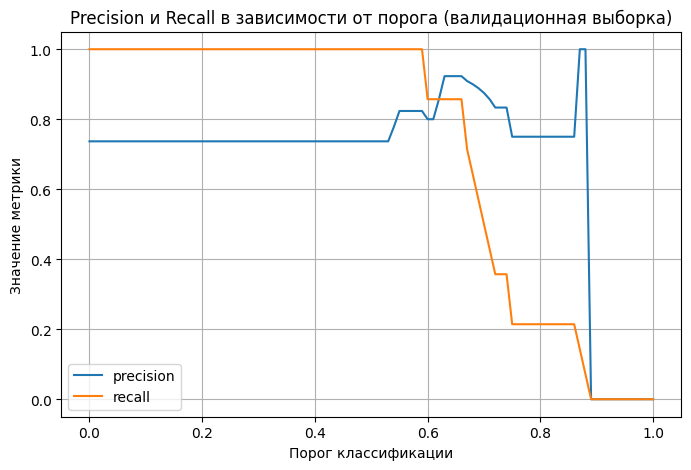

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="precision")
plt.plot(thresholds, recalls, label="recall")
plt.xlabel("Порог классификации")
plt.ylabel("Значение метрики")
plt.title("Precision и Recall в зависимости от порога (валидационная выборка)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
y_test_pred_logreg = (y_test_proba_logreg >= best_threshold).astype(int)
m_logreg = classification_metrics(y_test, y_test_pred_logreg)
auc_logreg = roc_auc(y_test, y_test_proba_logreg)

print("Метрики логистической регрессии (test):")
print("threshold:", best_threshold)
print("accuracy :", m_logreg['accuracy'])
print("precision:", m_logreg['precision'])
print("recall   :", m_logreg['recall'])
print("roc-auc  :", auc_logreg)
print("Матрица ошибок (tn, fp; fn, tp):\n", m_logreg['cm'])

metrics_test['logreg'] = {
    "accuracy": m_logreg['accuracy'],
    "precision": m_logreg['precision'],
    "recall": m_logreg['recall'],
    "roc_auc": auc_logreg,
    "cm": m_logreg['cm'].tolist(),
}

Метрики логистической регрессии (test):
threshold: 0.55
accuracy : 0.7
precision: 0.7368421052631579
recall   : 0.9333333333333333
roc-auc  : 0.4
Матрица ошибок (tn, fp; fn, tp):
 [[ 0  5]
 [ 1 14]]


### Задание 4: итоговая оценка качества моделей


**Задание 4. Оценка качества моделей.**

Сводим воедино значения accuracy, precision, recall и roc-auc по тестовой выборке
для всех построенных моделей и при необходимости выводим матрицы ошибок.


In [19]:
rows = []
for name, m in metrics_test.items():
    rows.append({
        "model": name,
        "accuracy": m["accuracy"],
        "precision": m["precision"],
        "recall": m["recall"],
        "roc_auc": m["roc_auc"],
    })

summary_df = pd.DataFrame(rows)
display(summary_df)

print("\nМатрицы ошибок для каждой модели:")
for name, m in metrics_test.items():
    print(f"\nМодель: {name}")
    print("Матрица ошибок (tn, fp; fn, tp):")
    print(np.array(m["cm"]))

,model,accuracy,precision,recall,roc_auc
0,baseline,0.75,0.750000,1.000000,0.626667
1,naive_bayes,0.70,0.736842,0.933333,0.426667
2,knn,0.70,0.736842,0.933333,0.426667
3,logreg,0.70,0.736842,0.933333,0.400000



Матрицы ошибок для каждой модели:

Модель: baseline
Матрица ошибок (tn, fp; fn, tp):
[[ 0  5]
 [ 0 15]]

Модель: naive_bayes
Матрица ошибок (tn, fp; fn, tp):
[[ 0  5]
 [ 1 14]]

Модель: knn
Матрица ошибок (tn, fp; fn, tp):
[[ 0  5]
 [ 1 14]]

Модель: logreg
Матрица ошибок (tn, fp; fn, tp):
[[ 0  5]
 [ 1 14]]
